In [1]:
#importing necessary libraries
from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [4]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [5]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [6]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [7]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [8]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [9]:
appendADS(censusTracts,branchInfo, 'driving score 5 min', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid',5)

api = MapboxAPI()
censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
censusAreas = []
#geod = Geod(ellps='WGS84')
censusTracts = censusTracts.set_crs('EPSG:4326')
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas



for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

In [10]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,list of dict
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.99322, -87.71461 41.992...",41.975579,-87.713613,"[{17031140800: 0.10910496440467443, 1703116050..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59684 41.69523, -87.59691 41.693...",41.657198,-87.598838,"[{17031825801: 0.1615035489776389, 17031826401..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.81848, -87.72559 41.816...",41.801108,-87.726484,"[{17031650200: 0.0254912176417698, 17031650100..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76482 41.90631, -87.76582 41.906...",41.889173,-87.765820,"[{17031252101: 0.39452842303857544, 1703181300..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78829 41.96819, -87.78833 41.962...",41.953123,-87.779285,"[{17031190402: 0.022557937206714188, 170311904..."
...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.70308, -87.64351 41.701...",41.677906,-87.643168,"[{17031821402: 0.990325261989984, 17031821200:..."
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.91073, -87.66881 41.909...",41.895947,-87.668293,"[{17031280100: 0.001197490335336308, 170318381..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.63095 41.78607, -87.63108 41.779...",41.751018,-87.614951,"[{17031490200: 0.006124736067597431, 170314409..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.74373, -87.64405 41.744...",41.720695,-87.643048,"[{17031750500: 0.002029252118561393, 170317506..."


In [11]:
censusTracts.sort_values(by = 'driving score 5 min', ascending = False)

,geoid,qualifying name,geometry,driving score 5 min,Area
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",3.656036,4.965761e+05
323,17031351500,"Census Tract 3515, Cook County, Illinois","POLYGON ((-87.62907 41.82742, -87.62904 41.827...",3.561942,1.662212e+05
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",3.425128,8.388936e+05
377,17031832900,"Census Tract 8329, Cook County, Illinois","POLYGON ((-87.66666 41.87635, -87.66657 41.876...",3.159490,4.045824e+05
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",3.147072,4.354491e+05
...,...,...,...,...,...
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,1.902470e+07
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,1.799139e+05
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.000000,6.839449e+05
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",0.000000,1.930083e+04


Text(0.5, 1.0, 'Percent of Coverage')

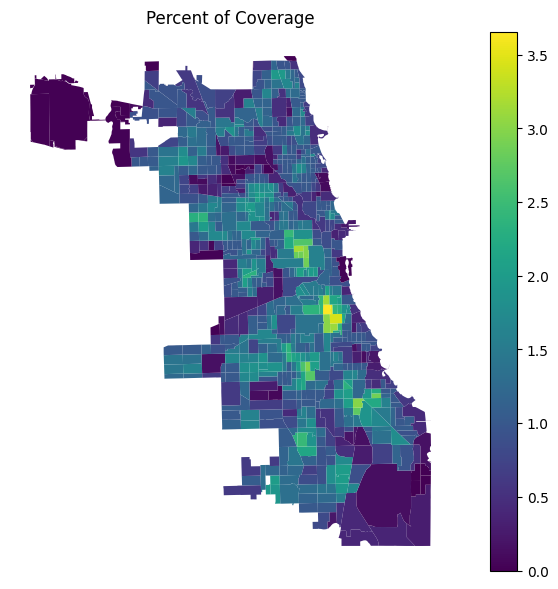

In [12]:
ax = censusTracts.plot(column = 'driving score 5 min', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [13]:
censusTracts['driving score 5 min'].mean()

1.0938034206665086

In [14]:
censusTracts['driving score 5 min norm'] = censusTracts['driving score 5 min']

In [15]:
censusTracts.loc[censusTracts['driving score 5 min norm'] > 1, 'driving score 5 min norm'] = 1.0
censusTracts.sort_values(by = 'driving score 5 min', ascending = False)

,geoid,qualifying name,geometry,driving score 5 min,Area,driving score 5 min norm
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",3.656036,4.965761e+05,1.0
323,17031351500,"Census Tract 3515, Cook County, Illinois","POLYGON ((-87.62907 41.82742, -87.62904 41.827...",3.561942,1.662212e+05,1.0
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",3.425128,8.388936e+05,1.0
377,17031832900,"Census Tract 8329, Cook County, Illinois","POLYGON ((-87.66666 41.87635, -87.66657 41.876...",3.159490,4.045824e+05,1.0
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",3.147072,4.354491e+05,1.0
...,...,...,...,...,...,...
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,1.902470e+07,0.0
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,1.799139e+05,0.0
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.000000,6.839449e+05,0.0
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",0.000000,1.930083e+04,0.0


Text(0.5, 1.0, 'Percent of Coverage')

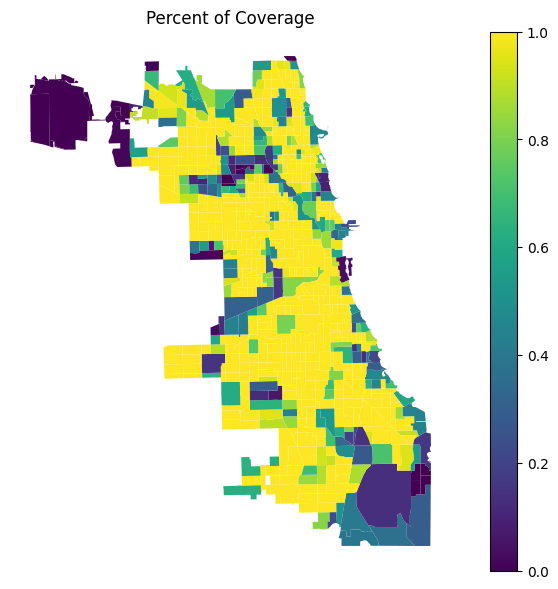

In [16]:
ax = censusTracts.plot(column = 'driving score 5 min norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")